# Predicting Building Energy Use

<img src="https://www.pikpng.com/pngl/m/152-1524338_overlay-city-drawing-easy-city-landscape-drawing-clipart.png" alt="Overlay City Drawing - Easy City Landscape Drawing Clipart@pikpng.com" class="center">

## Business Understanding

Buildings account for 76% of all electricity use in the United States. This translates to 40% of total greenhouse gas emissions from baseline power (coal and oil). Over half of a buildings energy draw comes from environment control:

* lighting
* cooling
* heating
* ventilation
* refrigeration

<img src="images/piechart.png" class="center">

New York State Energy Plan:

*"The State Energy Plan is a comprehensive roadmap to build a clean, resilient, and affordable energy system for all New Yorkers. The Plan coordinates every State agency and authority that touches energy to advance the REV agenda, unleashing groundbreaking regulatory reform to integrate clean energy into the core of our power grid, redesigning programs to unlock private capital, and actively deploying innovative energy solutions across the State’s own public facilities and operations."* ([EnergyPlan.NY.gov](https://energyplan.ny.gov/))

The plan has the following goals for the state:

* 40% reduction in greenhouse gas emissions from 1990 levels
* 50% of energy generation from renewable energy sources
* 600 trillion Btu increase in statewide energy efficiency

Being able to predict the annual electricity usage of a building based on it's size, primary use and energy efficiency rating would allow for better municipal planning and could help with identifying buildings that over-consume. This would be ideal for planning city sustainability projects as energy consumption could be predicted based on a forecasted change in energy efficiency of buildings. Based on required energy reductions predicted by this model the state could tailor sustainability programs to incentivize building managers to increase energy efficiency (reduce energy consumption).



## Data Understanding

**Target Variable - Annual Energy Usage (kW h):**

Energy use is typically tracked in kWh using electric meters installed by a utility company. NYC's Local Law 87 requires that buildings over 50,000 sqft undergo energy audits which include accurate, annual reporting of energy usage. Over 30,000 buildings within New York City fall under this law.

<img src="images/smart_meter.jpg" class="center">

**Building Energy Efficiency:**

A building's EnergyStar Score is a relative benchmark to other buildings of similar qualities. The higher the score the more energy efficient that building is. An EnergyStar Score of 50 is the median energy efficiency. In the state of New York, buildings above an EnergyStar Score of 70 are eligible for rebates through special state run programs.

**Primary Use:**

The primary use of a building is a general building classification. The top 5 classifications:
1. Multifamily Housing
2. Office
3. K-12 School
4. College/University
5. Hotel

## Data Exploration

Below the necessary imports are loaded.

In [70]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from statsmodels.formula.api import ols
from statsmodels.api import qqplot

from scipy import stats

The data comes from [NYC Open Data](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd). The target column is the 'Electricity Use - Grid Purchase (kWh)'. Here, the dataset is read in and the used columns are filtered for.

In [71]:
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2018__Data_for_Calendar_Year_2017_.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,31,32,111,113,127,206,236,237,238) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [72]:
dfx = df.filter(['Primary Property Type - Self Selected','Largest Property Use Type - Gross Floor Area (ft²)','Year Built','ENERGY STAR Certification - Eligibility','Electricity Use - Grid Purchase (kWh)']).copy(deep=True)

Dropping Buildings that do not have all the required input variables

In [73]:
dfx.dropna(inplace=True)
print('Starting Buildings Count:',df.shape[0],'|','Starting Columns Count:',df.shape[1])
print('Buildings Count:',dfx.shape[0],'|','Feature Count:',dfx.shape[1]-1)

Starting Buildings Count: 34686 | Starting Columns Count: 256
Buildings Count: 31864 | Feature Count: 4


## Data Cleaning

Label encoding the EnergyStar Certification Eligibility column. Reminder - buildings who meet the eligibility have an EnergyStar Score of 70 or greater (in the top 30% of energy performance relative to similar buildings).

In [74]:
def energystar(x):
    if x == 'No':
        return 0
    else:
        return 1

dfx['ENERGY STAR Certification - Eligibility'] = dfx['ENERGY STAR Certification - Eligibility'].map(energystar)

Renaming building primary uses to all be in English.

In [75]:
def use_cleanup(x):
    if x == 'Collège/Université':
        return 'College/University'
    elif x == 'Immeuble à logements multiples':
        return 'Multifamily Housing'
    else:
        return x

dfx['Primary Property Type - Self Selected'] = dfx['Primary Property Type - Self Selected'].map(use_cleanup)

For this model we only want to look at buildings that have active electricity usage so any building with no usage is removed. Also, outliers more than 3 standard deviations from mean for electricity use are also removed.

In [76]:
before_drop_count = dfx.shape[0]
dfx = dfx[dfx['Electricity Use - Grid Purchase (kWh)'] > 0]
dfx = dfx[(np.abs(stats.zscore(dfx['Electricity Use - Grid Purchase (kWh)'])) < 3)]

In [77]:
print('Building Count Before Drop:',before_drop_count)
print('Building Count After Drop:',dfx.shape[0])
print('% Drop:',round((1-dfx.shape[0]/before_drop_count)*100,1))

Building Count Before Drop: 31864
Building Count After Drop: 31385
% Drop: 1.5


Train/Test Split

In [78]:
X_train,X_test,y_train,y_test = train_test_split(dfx.drop(['Electricity Use - Grid Purchase (kWh)'],axis=1),dfx['Electricity Use - Grid Purchase (kWh)'],random_state=42)

One Hot Encoding the Primary Use Input Variable. There are 86 unique building classifiers used in the training data.

In [79]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe_train_array = ohe.fit_transform(X_train[['Primary Property Type - Self Selected']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test[['Primary Property Type - Self Selected']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train,ohe_train_df],axis=1)
X_train_ohe.drop(['Primary Property Type - Self Selected'],axis=1,inplace=True)

X_test.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test,ohe_test_df],axis=1)
X_test_ohe.drop(['Primary Property Type - Self Selected'],axis=1,inplace=True)

In [80]:
print('Number of Features Pre OHE:',X_train.shape[1])
print('Number of Features Post OHE:',X_train_ohe.shape[1])

Number of Features Pre OHE: 4
Number of Features Post OHE: 88


## Modeling

### Simple Model

For the initial model 

In [81]:
lr = LinearRegression()
lr.fit(X_train_ohe,y_train)
lr.score(X_test_ohe,y_test)

0.6001622860048685

In [82]:
np.sqrt(mean_squared_error(y_test,lr.predict(X_test_ohe)))

933390.9447842129

### Simple Model Evaluation

#### Checking Normal Distribution of Input Variables

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

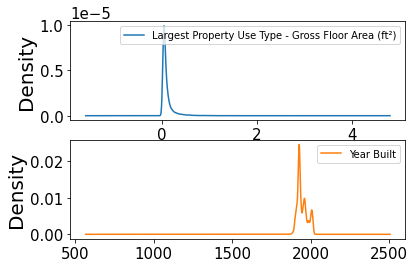

In [83]:
X_train_ohe.filter(['Largest Property Use Type - Gross Floor Area (ft²)','Year Built'],axis=1).plot.kde(subplots=True,sharex=False)

#### Checking Normal Distribution of Residuals

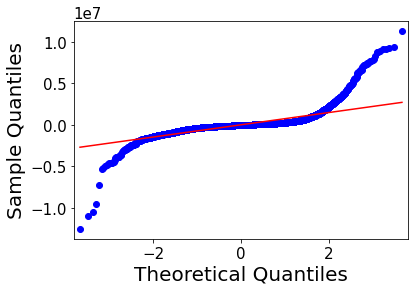

In [84]:
qqplot(y_test-lr.predict(X_test_ohe),line='r')
plt.show()

#### Checking for Heteroskedasticity of Residuals

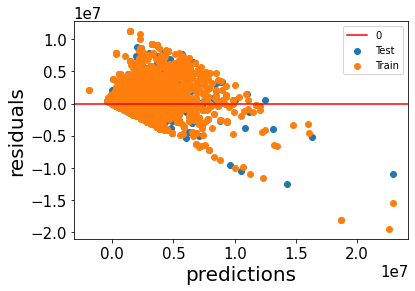

In [85]:
plt.scatter(lr.predict(X_test_ohe), y_test-lr.predict(X_test_ohe), label='Test')
plt.scatter(lr.predict(X_train_ohe), y_train-lr.predict(X_train_ohe), label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

#### Checking Multicollinearity of Input Variables

<AxesSubplot:>

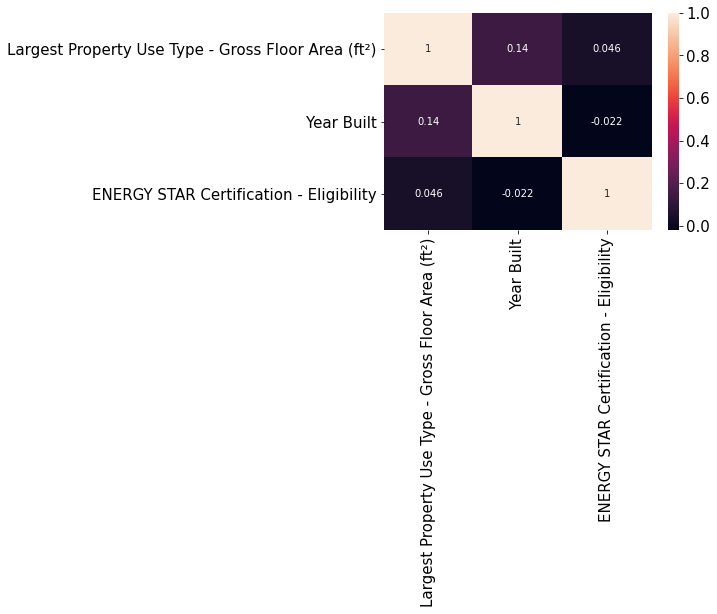

In [86]:
sns.heatmap(X_train.corr(),annot=True)

### Final Model

In [87]:
rfr = RandomForestRegressor()

In [88]:
# rfe = RFE(rfr,n_features_to_select=30)
# rfe.fit(X_train_ohe,y_train)

In [ ]:
# final_list = ['Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built', 'ENERGY STAR Certification - Eligibility', 'College/University', 'Data Center', 'Distribution Center', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Manufacturing/Industrial Plant', 'Medical Office', 'Mixed Use Property', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Mall', 'Other - Specialty Hospital', 'Outpatient Rehabilitation/Physical Therapy', 'Pre-school/Daycare', 'Refrigerated Warehouse', 'Residential Care Facility', 'Résidence pour personnes âgées', 'Résidence/dortoir', 'Stadium (Open)', 'Supermarché/épicerie', 'Transportation Terminal/Station']

In [89]:
keep_list = [(k,v) for k,v in zip(X_train_ohe.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
final_list = [ x[0] for x in keep_list if x[1] ]

In [90]:
rfr.fit(X_train_ohe.filter(final_list),y_train)

RandomForestRegressor()

In [100]:
final_list

['Largest Property Use Type - Gross Floor Area (ft²)',
 'Year Built',
 'ENERGY STAR Certification - Eligibility',
 'College/University',
 'Data Center',
 'Distribution Center',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Mixed Use Property',
 'Movie Theater',
 'Multifamily Housing',
 'Museum',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Mall',
 'Other - Specialty Hospital',
 'Outpatient Rehabilitation/Physical Therapy',
 'Pre-school/Daycare',
 'Refrigerated Warehouse',
 'Residential Care Facility',
 'Résidence pour personnes âgées',
 'Résidence/dortoir',
 'Stadium (Open)',
 'Supermarché/épicerie',
 'Transportation Terminal/Station']

In [91]:
# params = {'n_estimators':np.linspace(10,400,num=10,dtype=int),
#           'max_depth': np.linspace(1,10,num=5,dtype=int),
#           'min_samples_split': np.linspace(2,10,num=5,dtype=int)}
# gs = GridSearchCV(rfr,params)
# gs.fit(X_train_ohe,y_train)
# gs.best_params_

In [92]:
best_params = {'max_depth': 27, 'min_samples_split': 2, 'n_estimators': 183}

In [93]:
rfr = RandomForestRegressor(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'],n_estimators=best_params['n_estimators'])
rfr.fit(X_train_ohe.filter(final_list),y_train)

RandomForestRegressor(max_depth=27, n_estimators=183)

In [94]:
rfr.score(X_test_ohe.filter(final_list),y_test)

0.7837877151174573

Cross Validation to check for overfitting.

In [95]:
cross_val_score(rfr,X_train_ohe.filter(final_list),y_train)

array([0.79135096, 0.73499311, 0.75914627, 0.79365478, 0.74756317])

In [96]:
y_hat_train = rfr.predict(X_train_ohe.filter(final_list))
print('RMSE Train Data:',round(np.sqrt(mean_squared_error(y_train,y_hat_train))))
y_hat_test = rfr.predict(X_test_ohe.filter(final_list))
print('RMSE Test Data:',round(np.sqrt(mean_squared_error(y_test,y_hat_test))))

RMSE Train Data: 270283.0
RMSE Test Data: 686376.0


## Findings

The final model is able to predict a building's annual electricity usage from the grid to within 664,300 kW h. This is half of a standard deviation of annual usages for the full dataset.

In [97]:
dfx[['Electricity Use - Grid Purchase (kWh)']].describe()

,Electricity Use - Grid Purchase (kWh)
count,3.138500e+04
mean,8.682638e+05
std,1.488068e+06
min,1.200000e+01
25%,2.022693e+05
50%,3.649222e+05
75%,8.111999e+05
max,1.340799e+07


#### Visualizing Top Energy Users

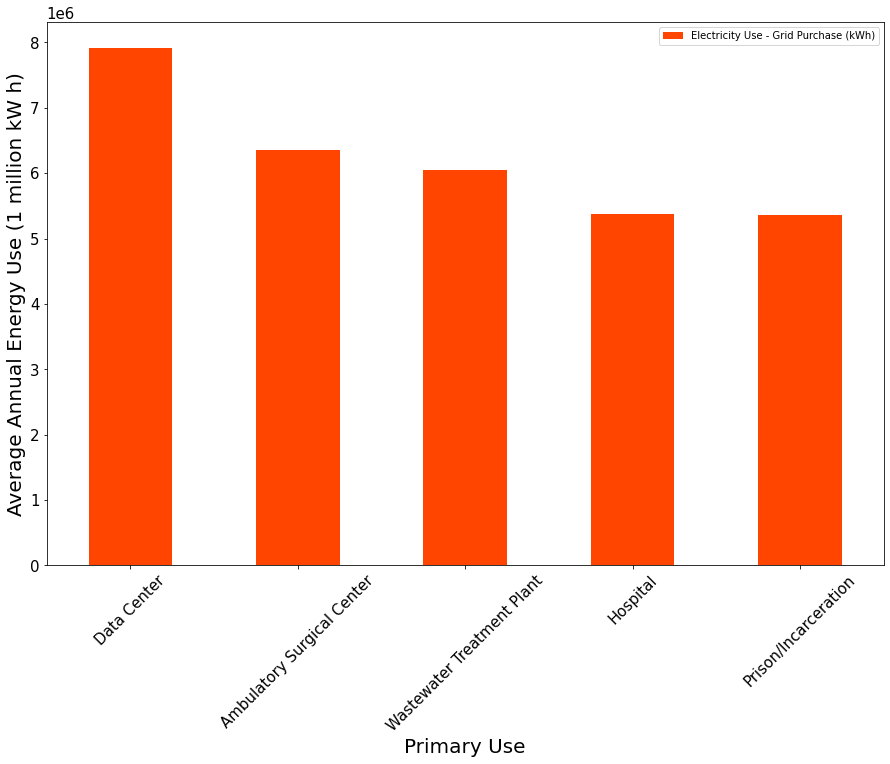

In [98]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

def change_ent(x):
    if x == 'Hospital (General Medical & Surgical)':
        return 'Hospital'
    elif x == 'Refrigerated Warehouse':
        return 'Ref Warehouse'
    elif x == 'Non-Refrigerated Warehouse':
        return 'Non-Ref Warehouse'
    else:
        return x

dfx['Primary Property Type - Self Selected'] = dfx['Primary Property Type - Self Selected'].map(change_ent)

dfx.groupby('Primary Property Type - Self Selected').mean()[['Electricity Use - Grid Purchase (kWh)']].sort_values('Electricity Use - Grid Purchase (kWh)',ascending=False)[:5].plot(kind='bar',rot=45,xlabel='Primary Use',ylabel='Average Annual Energy Use (1 million kW h)',figsize=(15,10),color=['orangered','orange'])
plt.show()

The top energy users fall into categories that typically have large square footage buildings and contain energy intensive processes.

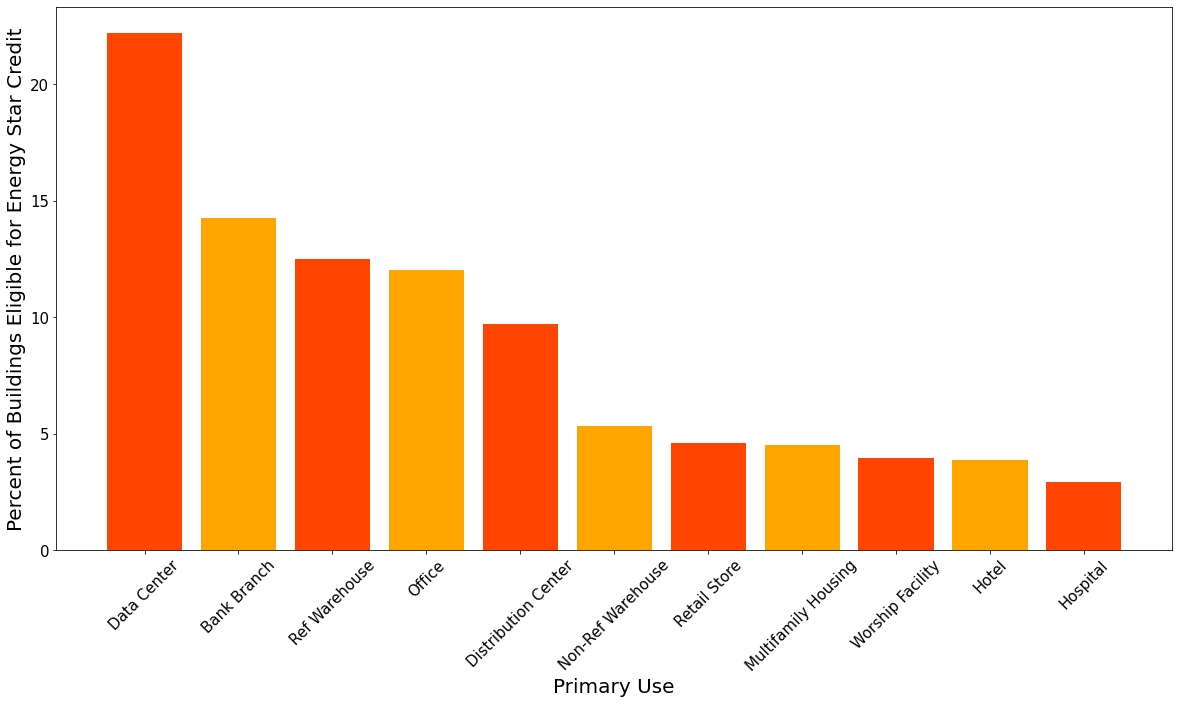

In [99]:
efficiency_list = []
for x in dfx.value_counts('Primary Property Type - Self Selected').index:
    temp_df = pd.DataFrame()
    temp_df = dfx[dfx['Primary Property Type - Self Selected'] == x]
    efficiency_list.append((x,temp_df['ENERGY STAR Certification - Eligibility'].sum()/temp_df.shape[0]*100))

efficiency_list.sort(key=lambda x: x[1],reverse=True)

final_effic_list = efficiency_list[17:28]

fig,ax = plt.subplots(figsize=(20,10))

ax.bar(x=[x[0] for x in final_effic_list],height=[y[1] for y in final_effic_list],color=['orangered','orange'])
ax.set(xlabel="Primary Use")
ax.set(ylabel="Percent of Buildings Eligible for Energy Star Credit")
plt.xticks(rotation=45)
plt.show()

The above graph shows the top performing primary uses by percentage of buildings that qualify for Energy Star Credit (70th percentile for energy efficiency). Ambulatory/Surgical Centers and Prisons while being in the top for energy consumption are not present in the top performing primary uses.

## Recommendations

- Focus energy efficiency incentive programs on high energy use buildings that have the highest percentage of low EnergyStar Scores (Prisons, Surgical Centers, Wastewater Treatment Plants)
- Forecast Energy Annual Usage by making predictions with targeted EnergyStar Scores

## Future Research

- Use sub-metering data in the model to include the exact energy use (HVAC,Lighting,Computers). For example, understanding which energy use by primary use of the building could help with creating more targeted incentive programs and recommended solutions.
- Incorporate weather data to show effects of seasonality on energy use